In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import DistanceMetric
from math import radians
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
from gurobipy import *
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
gdf = ox.geocode_to_gdf("Wuerzburg, Germany")
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((9.87163 49.79715, 9.87167 49.79702, ...",49.845462,49.710684,10.014429,9.871628,256375941,relation,62464,49.79245,9.932966,"Würzburg, Bavaria, Germany",boundary,administrative,0.729286


In [ ]:
# When not specified network_type="drive" we get a lot more edges/nodes
G = ox.graph_from_place("Wuerzburg, Germany", buffer_dist= 5000)

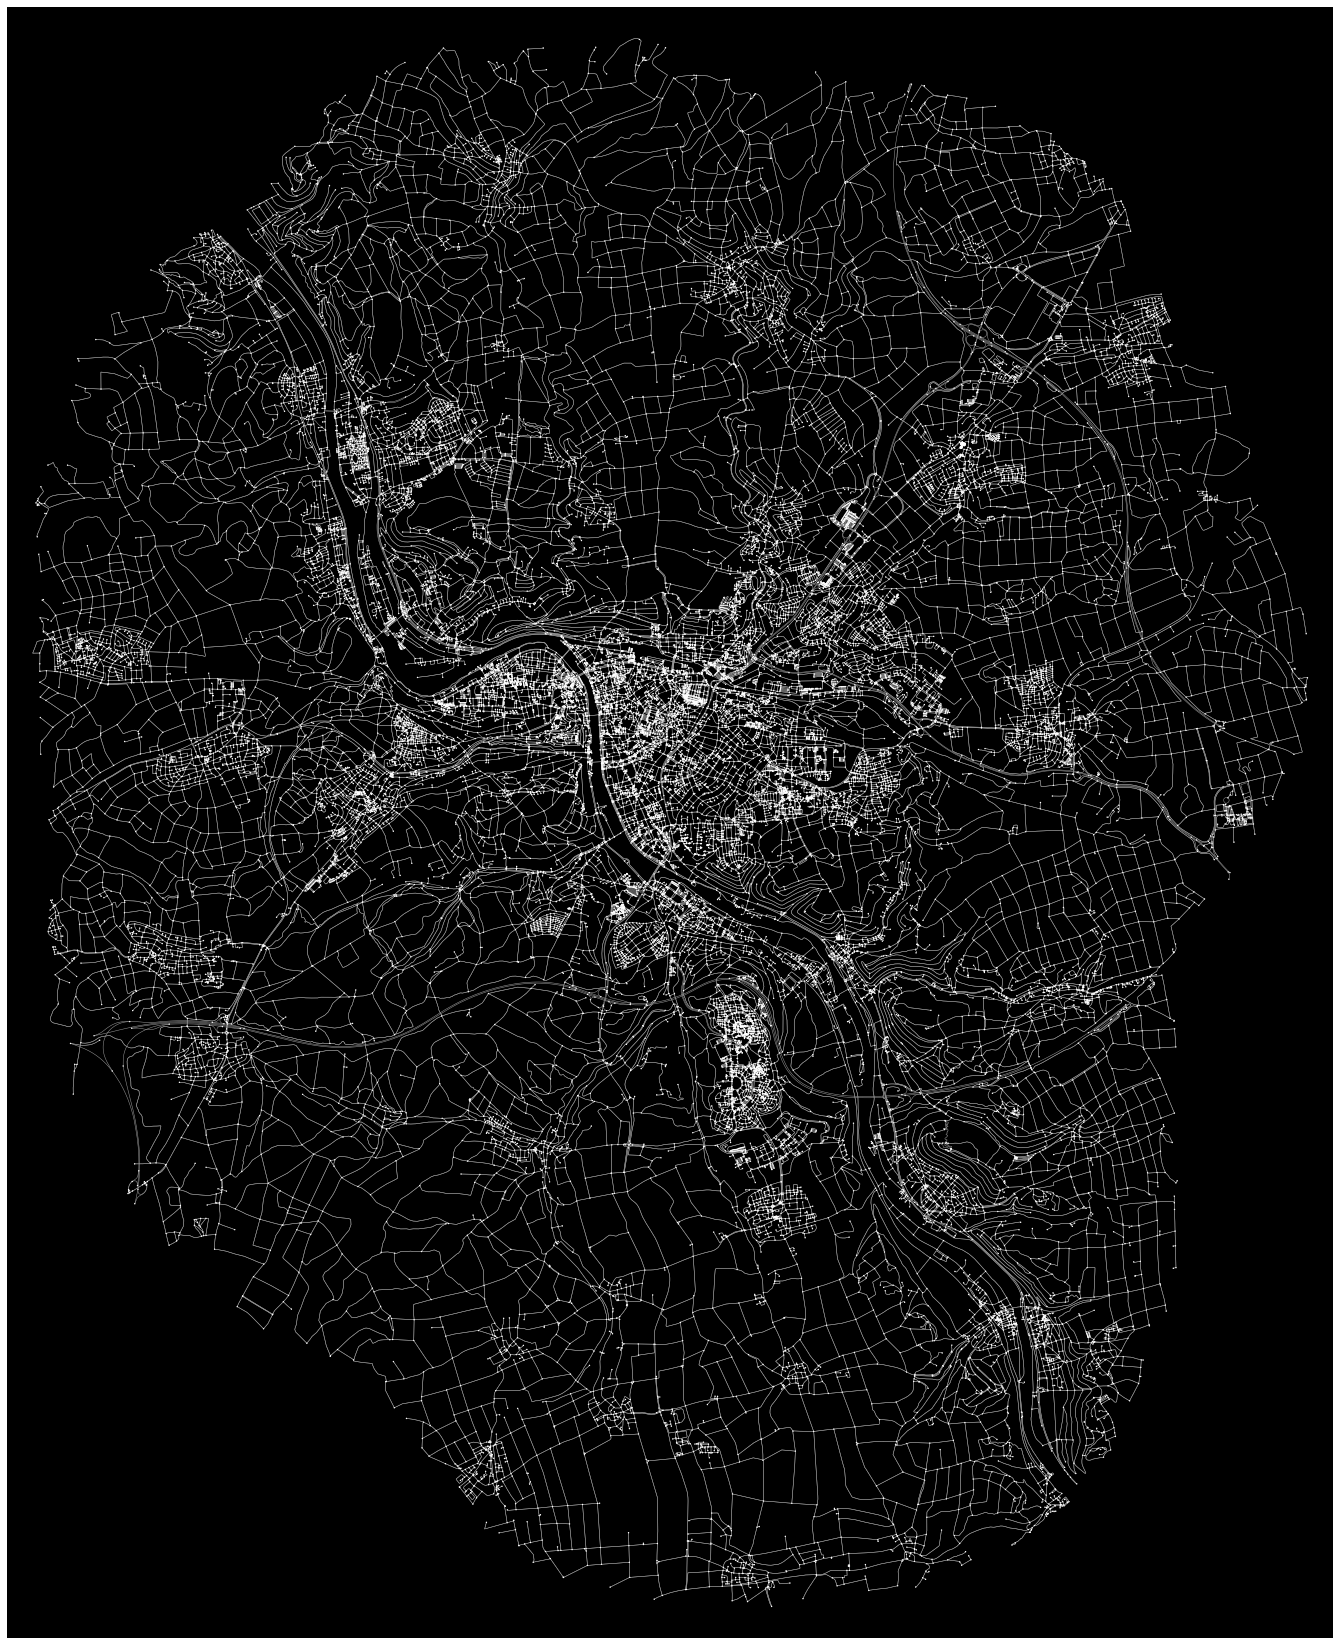

In [6]:
fig, ax = ox.plot_graph(G, node_size = 2, edge_linewidth = 0.5, node_color = "white", figsize = (30,30), bgcolor = "black")

In [7]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [8]:
nodes

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
580976,49.748455,9.848022,3,NaN,NaN,POINT (9.84802 49.74845)
580993,49.751875,9.933932,3,NaN,NaN,POINT (9.93393 49.75188)
584481,49.748507,9.824115,3,69,motorway_junction,POINT (9.82411 49.74851)
10799058,49.751452,9.926904,3,NaN,NaN,POINT (9.92690 49.75145)
10799066,49.753819,9.928881,3,NaN,NaN,POINT (9.92888 49.75382)
...,...,...,...,...,...,...
9164552888,49.759307,9.943024,1,NaN,NaN,POINT (9.94302 49.75931)
9164552889,49.759308,9.942880,3,NaN,NaN,POINT (9.94288 49.75931)
9165200504,49.814023,9.914432,1,NaN,NaN,POINT (9.91443 49.81402)


In [9]:
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
nodes, edges = ox.graph_to_gdfs(Gs, nodes=True, edges=True)
nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
580976,49.748455,9.848022,3,NaN,NaN,POINT (9.84802 49.74845)
580993,49.751875,9.933932,3,NaN,NaN,POINT (9.93393 49.75188)
10799058,49.751452,9.926904,3,NaN,NaN,POINT (9.92690 49.75145)
10799066,49.753819,9.928881,3,NaN,NaN,POINT (9.92888 49.75382)
10799083,49.751798,9.927970,3,NaN,NaN,POINT (9.92797 49.75180)
...,...,...,...,...,...,...
9164552888,49.759307,9.943024,1,NaN,NaN,POINT (9.94302 49.75931)
9164552889,49.759308,9.942880,3,NaN,NaN,POINT (9.94288 49.75931)
9165200504,49.814023,9.914432,1,NaN,NaN,POINT (9.91443 49.81402)


In [25]:
nodes_df = nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]
nodes_df

,lat,lon
osmid,,
580976,49.748455,9.848022
580993,49.751875,9.933932
10799058,49.751452,9.926904
10799066,49.753819,9.928881
10799083,49.751798,9.927970
...,...,...
9164552888,49.759307,9.943024
9164552889,49.759308,9.942880
9165200504,49.814023,9.914432


In [26]:
nodes_df.loc[9162051345]

lat    49.790196
lon    10.026296
Name: 9162051345, dtype: float64

In [10]:
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive", buffer_dist=5000)
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
mat_generator = nx.all_pairs_dijkstra_path_length(Gs, weight = "length")
mat_dict = dict(mat_generator)
mat = pd.DataFrame(mat_dict).round(1)
mat = mat.rename_axis("osmid").sort_values(by = ["osmid"])
mat

,580976,580993,10799058,10799066,10799083,10799085,10799087,10799089,10799100,10799937,...,8917704497,8957701515,8981470540,8995529939,9074832808,9078892454,9080957706,9092934947,9136289696,9162051345
osmid,,,,,,,,,,,,,,,,,,,,,
580976,0.0,20069.3,7851.6,11607.8,7793.7,7704.4,7402.3,7335.1,7079.4,9869.9,...,9879.5,15020.1,10480.5,4987.0,17426.2,17529.2,17302.4,12400.9,9736.3,17191.6
580993,6461.3,0.0,661.3,5186.5,684.1,594.8,980.9,13796.4,13540.8,3448.6,...,7357.0,13807.3,6174.3,8499.2,11498.5,11601.5,11374.7,7168.6,7172.6,11263.9
10799058,6054.1,13357.6,0.0,4595.5,93.1,650.3,389.9,13389.3,13133.6,2857.6,...,6765.9,13216.3,5583.3,7908.1,10907.5,11010.5,10783.6,6577.6,6581.6,10672.9
10799066,6524.6,12765.3,470.5,0.0,412.6,323.3,709.4,13859.7,13604.1,3177.1,...,7085.5,13535.8,5902.8,8227.6,11227.0,11330.0,11103.2,6897.1,6901.1,10992.4
10799083,6758.5,13264.5,704.3,4502.4,0.0,557.2,296.8,14093.6,13837.9,2764.5,...,6672.8,13123.2,5490.2,7815.0,10814.4,10917.4,10690.6,6484.5,6488.5,10579.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078892454,17236.3,16948.5,11182.1,10711.7,11124.3,11035.0,11421.1,23175.9,22920.3,8973.7,...,9114.4,15539.6,8931.9,12514.9,132.8,0.0,261.9,5625.8,8953.4,1138.5
9080957706,17009.4,16721.7,10955.3,10484.8,10897.4,10808.1,11194.2,22949.1,22693.4,8746.9,...,8887.6,15312.8,8705.1,12288.1,129.1,261.9,0.0,5398.9,8726.6,1082.5
9092934947,12644.5,15258.0,6590.4,6119.9,6532.5,6443.2,6829.3,18103.3,17847.6,4382.0,...,4373.3,10823.6,3822.5,7442.2,5753.8,5856.9,5630.0,0.0,4067.9,5519.2


In [27]:
# Number of Candidate DCs chosen from Facility Location Model
DC_N = 1

# List Creator for DCs
def createList_DC(r1, r2):
    return list(['DC%d'%x for x in range(r1, r2+1)])

#create an index
DC_ID = createList_DC(1, DC_N)

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [1500] * DC_N 

#Maximum Throughput at depot i = Vi
capacity_DC = [250] * DC_N

#Variable Warehousing Cost (Picking)
varCost_DC = [12, 15, 20, 30]

#Position of the DCs
lat_DC = [49.790196, 49.773391, 49.800460, 49.811422, 49.791321]
lon_DC = [10.026296, 9.923226, 9.951607, 9.981127, 9.953342]

# Osmid of the Dcs
osmid = [9162051345, 30747843, 40430241, 27352149, 27457548]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, varCost_DC, lat_DC, lon_DC, osmid))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon", "osmid"])
set_of_all_DC.set_index("DC_ID", inplace = True)

# Define Index I for model building
I = set_of_all_DC.index.values

# DC_S
DC_S = set_of_all_DC["osmid"].values.tolist()

set_of_all_DC

,fixed_cost_DC,capacity_DC,varCost_DC,lat,lon,osmid
DC_ID,,,,,,
DC1,1500,250,12,49.790196,10.026296,9162051345


In [28]:
# Sample Customers from osmnx

# Define Customer N and Demand per
customers = 10
demand_per_customer = 5

# Function to create a Customer Index List
def createList_C(r1, r2):
    return list(['C%d'%x for x in range(r1, r2+1)])

# Get all nodes in Würzburg from OSMNX which will be used to sample a certain amount of customers
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Gs)

# Create nodes_df which is the basis for our customer df
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]

#Sample from nodes_df
sample_nodes_df = nodes_df.sample(n = customers, random_state= 3)


#DF Manipulation
C_ID = createList_C(1,customers)
osmid = list(sample_nodes_df.index.values)
sample_nodes_df = sample_nodes_df.rename(index=dict(zip(osmid,C_ID)))
sample_nodes_df.index.name = "C_ID"
sample_nodes_df["osmid"] = osmid

#Create final demand column for customer DF
mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
# Add Demand column from the newly created list
set_of_all_customers['Demand_C'] = mylist
# Sort the df by osmid, this needs to be done for renaming purposes in the dist_matrix
set_of_all_customers = set_of_all_customers.sort_values(by=["osmid"])
# New index C1-C2 etc.
set_of_all_customers.reset_index(drop=True, inplace=True)
set_of_all_customers.index = C_ID
set_of_all_customers.index.names = ["C_ID"]
# Create Nodes_S for joining and plotting later
Nodes_S = set_of_all_customers["osmid"].tolist()
# Create index J for model building
J = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,osmid,Demand_C
C_ID,,,,
C1,49.781555,9.943229,29877216,5
C2,49.773253,9.954381,30255680,5
C3,49.776658,9.952296,40932452,5
C4,49.794972,9.957999,51519006,5
C5,49.800872,9.991186,101458357,5


In [29]:
Nodes_S = set_of_all_customers["osmid"].tolist()
Nodes_S1 = DC_S + Nodes_S
# By combining the lists in this way, the DCs are first and customers second
Nodes_S1

[9162051345,
 29877216,
 30255680,
 40932452,
 51519006,
 101458357,
 248813018,
 362242416,
 1032261863,
 6034416208,
 6533691138]

In [30]:
# Construct set of all vehicles K

#Vehicle Count
V_N = 3

# Vehicle List Creator
def createList_V(r1, r2):
    return list(['V_%d'%x for x in range(r1, r2+1)])

# create index
V_ID = createList_V(1, V_N)

# Vehicle Capacity Qk
capacity_V = [100] * V_N

# fixed cost of using Vehicle Fk
fixed_cost_V = [5] * V_N

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
K = set_of_all_vehicles.index.values
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,100,5
V_2,100,5
V_3,100,5


In [32]:
# Have to somehow adapt this code so that it works with C_IDs and DC_IDs. Map osmids to the DC/C_IDs, so we can have a distance matrix with those Indexs

# Join Distances for the sampled nodes from our Initial Distance Matrix for all nodes 
dist_matrix = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the distance matrix
dist_matrix = dist_matrix.rename_axis("osmid")
# Join new empty dist_matrix with filled matrix for every chosen node
dist_matrix = dist_matrix.merge(mat, left_index=True, right_index=True)
dist_matrix = dist_matrix[dist_matrix.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
dist_matrix = dist_matrix.reindex(columns=Nodes_S1)

# Have to replace column names and index values with more paletable values (osmids could confuse, need DC1 C1 etc.). Use the I and J arrays from Customer and DC Dataframes to form a list
nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
dist_matrix.columns = new_colnames
dist_matrix. index = new_colnames
dist_matrix

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
DC1,0.0,7149.5,6946.1,6772.0,5804.9,5775.1,9804.1,11219.6,11458.4,4978.1,10278.5
C1,7383.5,0.0,1492.5,1204.4,2002.9,5777.5,3030.2,4445.7,6443.0,2211.2,3504.6
C2,6980.7,1492.5,0.0,617.4,2954.2,6732.8,3741.8,5157.3,7935.5,3012.9,4216.3
C3,6788.6,1204.4,617.4,0.0,2699.7,6478.2,3233.9,4649.3,7625.6,2758.3,3708.3
C4,6038.8,2002.9,3002.3,2747.7,0.0,4591.4,4925.7,6274.0,6705.2,866.6,5400.1
C5,5724.8,5615.9,6285.2,6030.7,4515.6,0.0,8454.1,9589.8,8924.3,3649.0,8928.5
C6,10194.7,3411.0,4115.9,3607.9,5299.8,9074.4,0.0,3655.5,8650.4,5508.2,2304.9
C7,10833.2,4049.4,4754.4,4246.4,5938.2,9712.9,3911.6,0.0,8345.0,6146.6,4287.3
C8,11288.0,6279.2,7771.6,7461.7,6670.8,9099.8,8926.9,8299.5,0.0,6879.2,9225.3
C9,5212.0,2211.2,2636.2,2381.7,866.6,3724.8,5134.1,6482.3,6913.6,0.0,5608.5


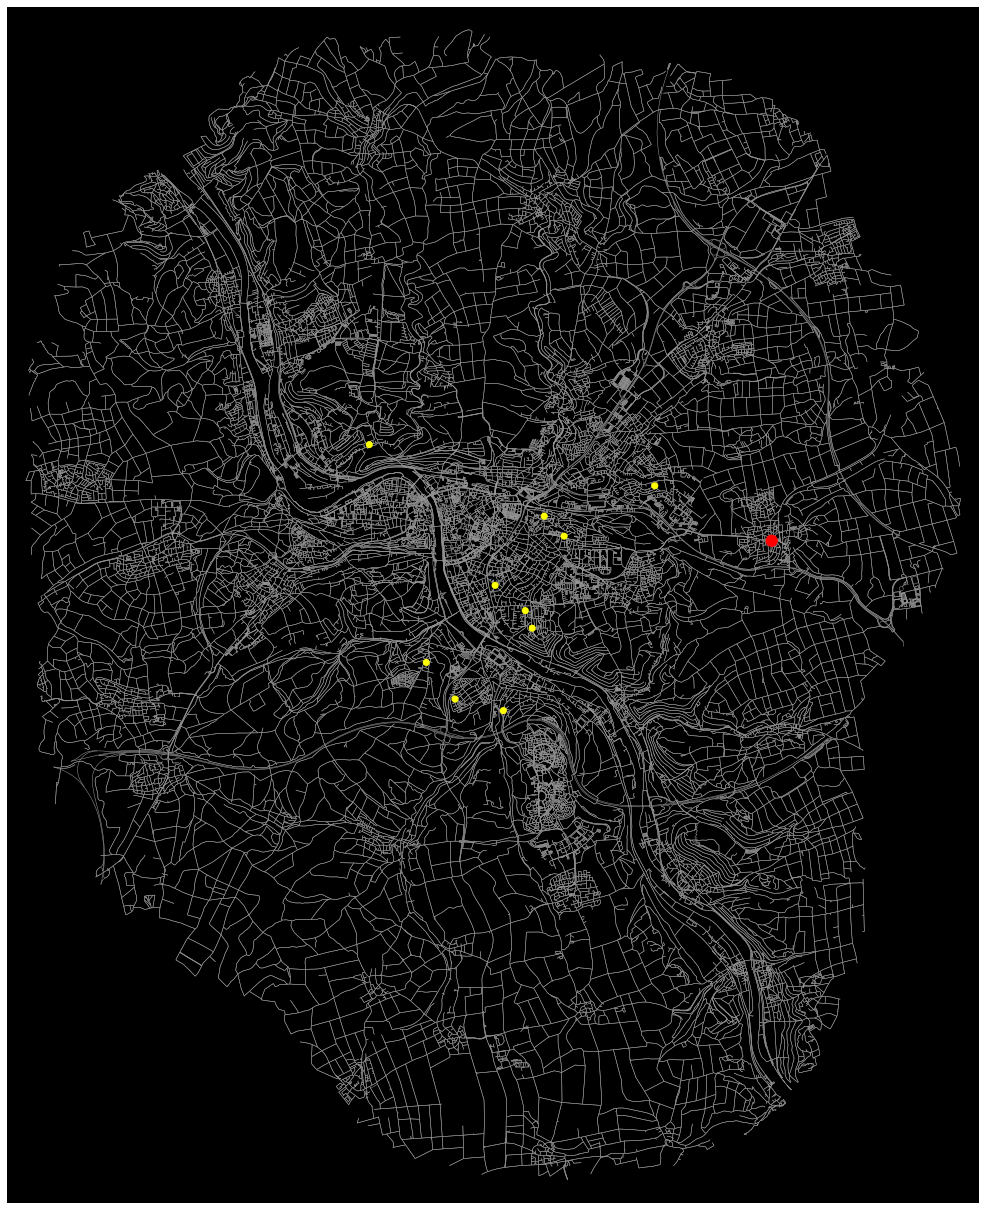

In [34]:
place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, buffer_dist=5000)


nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

ns = []
for node in G.nodes():
    if node in DC_S:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in G.nodes():
    if node in DC_S: 
        nc.append("red")
    elif node in Nodes_S:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")